In [33]:
import tntorch as tt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../tacotron2/")
sys.path.insert(0, "../waveglow/")

import librosa
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.display import Audio

from audio.vocoders import griffin_lim
from tacotron2.model import Tacotron2
from tacotron2.text import text_to_sequence, sequence_to_text
from waveglow.glow import WaveGlow

%matplotlib inline

In [8]:
# Tacotron 2
TACOTRON_CONFIG=json.load(open('../tacotron2/config.json', 'r'))
TACOTRON_CHECKPT='../checkpoints/tacotron2_statedict.pt'

# Waveglow
WAVEGLOW_CONFIG=json.load(open('../waveglow/config.json', 'r'))
WAVEGLOW_CHECKPT='../checkpoints/waveglow_256channels_ljs_v3.pt'

# Essential
ON_GPU=False
MAX_WAV_VALUE=32768.0
SIGMA=1.1

In [9]:
tacotron2 = Tacotron2(TACOTRON_CONFIG)
checkpt_state_dict = torch.load(TACOTRON_CHECKPT,
                                map_location=lambda storage, loc: storage)['state_dict']
tacotron2.load_state_dict(checkpt_state_dict)
_ = tacotron2.cuda().eval() if ON_GPU else tacotron2.cpu().eval()

print('Number of parameters:', tacotron2.nparams())

Number of parameters: 28193153


In [16]:
W = tacotron2.decoder.prenet.layers[0].linear_layer.weight.data
W.shape

torch.Size([256, 80])

In [69]:
W_tt = tt.Tensor(W, ranks_tt=15)

In [70]:
W_tt

2D TT tensor:

 256 80
  |   |
 (0) (1)
 / \ / \
1   15  1

In [71]:
[core.shape for core in W_tt.cores]

[torch.Size([1, 256, 15]), torch.Size([15, 80, 1])]

In [72]:
print('Compression ratio: {}/{} = {:g}'.format(W.numel(), W_tt.numcoef(), W.numel() / W_tt.numcoef()))
print('Relative error:', tt.relative_error(W, W_tt))
print('RMSE:', tt.rmse(W, W_tt))
print('R^2:', tt.r_squared(W, W_tt))

Compression ratio: 20480/5040 = 4.06349
Relative error: tensor(0.5161)
RMSE: tensor(0.0464)
R^2: tensor(0.7337)


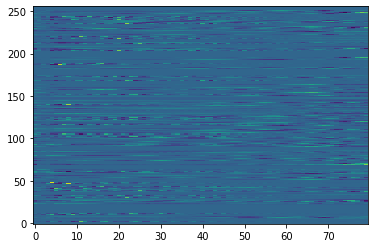

In [73]:
plt.imshow(W, aspect='auto', origin='bottom');

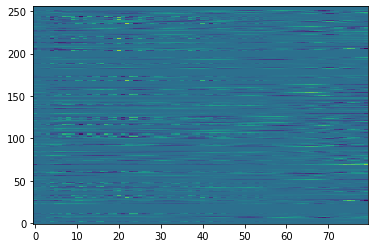

In [74]:
plt.imshow(W_tt.torch(), aspect='auto', origin='bottom');

In [77]:
W.shape, W_tt.shape

(torch.Size([256, 80]), torch.Size([256, 80]))

In [86]:
W @ W_tt.torch().T

tensor([[-0.0000e+00, -0.0000e+00, -2.0753e-40,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [ 1.4013e-45, -0.0000e+00, -8.2083e-40,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [ 9.4329e-09, -2.3547e-08,  3.2054e-01,  ..., -8.1069e-38,
          1.9262e-38, -3.0362e-36],
        ...,
        [-4.3440e-44, -8.4078e-44, -8.1070e-38,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [ 2.3402e-43, -7.8473e-44,  1.9260e-38,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [-1.3024e-39, -6.8368e-40, -3.0377e-36,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00]])

In [93]:
tacotron2.encoder.lstm.state_dict().keys()

odict_keys(['weight_ih_l0', 'weight_hh_l0', 'bias_ih_l0', 'bias_hh_l0', 'weight_ih_l0_reverse', 'weight_hh_l0_reverse', 'bias_ih_l0_reverse', 'bias_hh_l0_reverse'])

In [92]:
tacotron2.encoder.lstm.state_dict()['weight_ih_l0'].shape

torch.Size([1024, 512])